In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)   

data = pd.read_csv('DATA_PROVINSI.csv')
data_kecelakaan = data['jumlah_kecelakaan']
X = data_kecelakaan[:-1].values.reshape(-1,1)
y = data_kecelakaan[1:].values.reshape(-1,1).ravel()

df = pd.DataFrame(data)

# Pastikan jumlah sampel dan target sama
assert len(X) == len(y), "Jumlah sampel dan target harus sama"

# Membagi kolom tanggal menjadi tahun dan bulan
df['tahun'] = df['tahun_bulan'].apply(lambda x: int(x.split('-')[0]))
df['bulan'] = df['tahun_bulan'].apply(lambda x: int(x.split('-')[1]))

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Memisahkan fitur dan target
X = df[['tahun', 'bulan']].values
y = df['jumlah_kecelakaan'].values

In [3]:
# Pisahkan data menjadi training dan testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [4]:
# Fungsi untuk menghitung MAPE menggunakan model SVR dengan parameter tertentu
def calculate_mape(X_train, y_train, X_val, y_val, params):
    C, epsilon, gamma = params
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred) * 100
    return mape

# Inisialisasi populasi awal
def initialize_population(population_size, parameter_ranges):
    population = []
    for _ in range(population_size):
        chromosome = []
        for param_range in parameter_ranges:
            param_value = np.random.uniform(param_range[0], param_range[1])
            chromosome.append(param_value)
        population.append(chromosome)
    return population

# Seleksi individu berdasarkan nilai fitness (MAPE)
def selection(population, X_train, y_train, X_val, y_val):
    selected_population = []
    for chromosome in population:
        mape = calculate_mape(X_train, y_train, X_val, y_val, chromosome)
        selected_population.append((chromosome, mape))
    selected_population.sort(key=lambda x: x[1])  # Sort berdasarkan MAPE terendah
    return selected_population[:len(population)//2]  # Pilih setengah individu terbaik

# Crossover: Menghasilkan keturunan dari pasangan individu terpilih
def crossover(selected_population):
    new_population = []
    ukuran_populasi = len(selected_population)
    
    for i in range(ukuran_populasi):
        parent1 = selected_population[i][0]
        
        # Tentukan parent2 dengan pemeriksaan batas
        if i % 2 == 0:
            if i - 1 >= 0:
                parent2 = selected_population[i-1][0]
            else:
                parent2 = selected_population[i][0]  # Penanganan alternatif jika i-1 tidak valid
        else:
            if i + 1 < ukuran_populasi:
                parent2 = selected_population[i+1][0]
            else:
                parent2 = selected_population[i][0]  # Penanganan alternatif jika i+1 tidak valid
        
        crossover_point = np.random.randint(1, len(parent1)-1)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        new_population.append(child)
    
    return new_population

# Mutasi: Mengubah nilai gen secara acak pada populasi baru
def mutation(new_population, mutation_rate, parameter_ranges):
    for i in range(len(new_population)):
        if np.random.random() < mutation_rate:
            mutated_gene_index = np.random.randint(0, len(new_population[i]))
            new_value = np.random.uniform(parameter_ranges[mutated_gene_index][0], parameter_ranges[mutated_gene_index][1])
            new_population[i][mutated_gene_index] = new_value
    return new_population

In [5]:
crossover_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
mutation_rates = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

parameter_ranges = [(0.0001, 50), (1e-07, 5), (1e-07, 5)]
results = []

# Konfigurasi eksperimen
num_generations = 125  # Ganti jumlah generasi menjadi 125 sesuai dengan pertanyaan
population_size = 50  # Ganti ukuran populasi menjadi 50 sesuai dengan pertanyaan

# Mencari kombinasi optimal dari tingkat crossover dan mutasi
best_cx_prob = None
best_mut_prob = None
best_mape = float('inf')

for cx_prob, mut_prob in zip(crossover_rates, mutation_rates):
    print(f"\nEvaluasi dengan crossover rate: {cx_prob}, mutation rate: {mut_prob}")
    
    crossover_rate = cx_prob
    mutation_rate = mut_prob
    
    population = initialize_population(population_size, parameter_ranges)
    
    for generation in range(num_generations):
        selected_population = selection(population, X_train, y_train, X_val, y_val)
        new_population = crossover(selected_population)
        new_population = mutation(new_population, mutation_rate, parameter_ranges)

        # Adjust the population size if necessary
        if len(new_population) < population_size:
            additional_individuals = initialize_population(population_size - len(new_population), parameter_ranges)
            new_population.extend(additional_individuals)
        elif len(new_population) > population_size:
            new_population = new_population[:population_size]

        # Make sure the new population has the correct size
        assert len(new_population) == population_size, "Ukuran populasi baru tidak sesuai"

        population = new_population

    # Mengambil individu terbaik (dengan MAPE terendah) dari populasi terakhir
    best_chromosome, best_population_mape = min(selected_population, key=lambda x: x[1])
    results.append((cx_prob, mut_prob, best_population_mape))

    print(f"MAPE terbaik untuk crossover rate {cx_prob} dan mutation rate {mut_prob}: {best_population_mape}")

    if best_population_mape < best_mape:
        best_mape = best_population_mape
        best_cx_prob = cx_prob
        best_mut_prob = mut_prob

print(f"\nKombinasi terbaik:")
print(f"Crossover rate: {best_cx_prob}")
print(f"Mutation rate: {best_mut_prob}")
print(f"MAPE terbaik: {best_mape}")


Evaluasi dengan crossover rate: 0, mutation rate: 1
MAPE terbaik untuk crossover rate 0 dan mutation rate 1: 59.347259044640566

Evaluasi dengan crossover rate: 0.1, mutation rate: 0.9
MAPE terbaik untuk crossover rate 0.1 dan mutation rate 0.9: 59.082398733470534

Evaluasi dengan crossover rate: 0.2, mutation rate: 0.8
MAPE terbaik untuk crossover rate 0.2 dan mutation rate 0.8: 61.19713217623504

Evaluasi dengan crossover rate: 0.3, mutation rate: 0.7
MAPE terbaik untuk crossover rate 0.3 dan mutation rate 0.7: 47.976595592797146

Evaluasi dengan crossover rate: 0.4, mutation rate: 0.6
MAPE terbaik untuk crossover rate 0.4 dan mutation rate 0.6: 46.0579164035213

Evaluasi dengan crossover rate: 0.5, mutation rate: 0.5
MAPE terbaik untuk crossover rate 0.5 dan mutation rate 0.5: 47.380711858316275

Evaluasi dengan crossover rate: 0.6, mutation rate: 0.4
MAPE terbaik untuk crossover rate 0.6 dan mutation rate 0.4: 46.714568403315255

Evaluasi dengan crossover rate: 0.7, mutation rate:

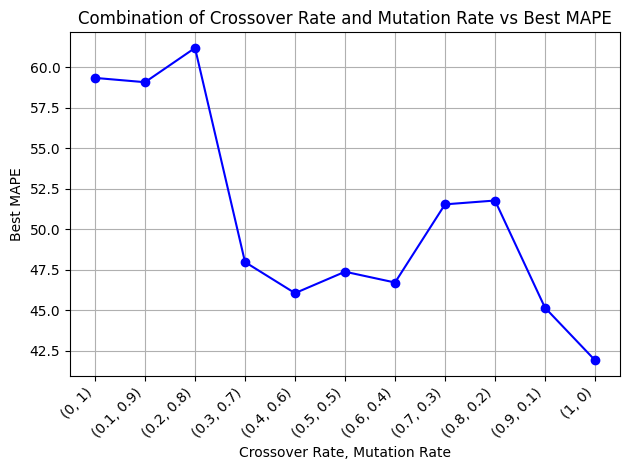

In [6]:
# Extracting data for plotting
crossover_values = [result[0] for result in results]
mutation_values = [result[1] for result in results]
mape_values = [result[2] for result in results]
labels = [f"({cx}, {mut})" for cx, mut in zip(crossover_values, mutation_values)]

# Plotting 2D scatter plot with annotations and lines
plt.plot(range(len(mape_values)), mape_values, marker='o', linestyle='-', color='blue')

plt.xlabel('Crossover Rate, Mutation Rate')
plt.ylabel('Best MAPE')
plt.title('Combination of Crossover Rate and Mutation Rate vs Best MAPE')
plt.grid(True)

plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

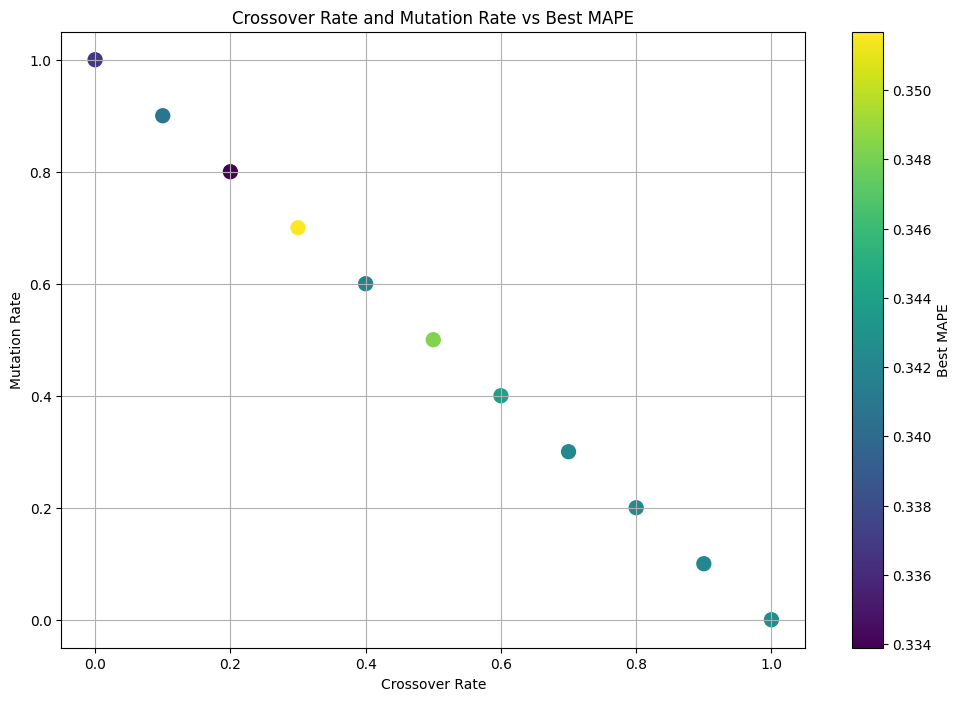

In [8]:
# Extracting data for plotting
crossover_values = [result[0] for result in results]
mutation_values = [result[1] for result in results]
mape_values = [result[2] for result in results]

# Plotting 2D scatter plot with color mapping
plt.figure(figsize=(12, 8))
scatter = plt.scatter(crossover_values, mutation_values, c=mape_values, cmap='viridis', s=100, marker='o')
plt.xlabel('Crossover Rate')
plt.ylabel('Mutation Rate')
plt.title('Crossover Rate and Mutation Rate vs Best MAPE')
plt.colorbar(scatter, label='Best MAPE')
plt.grid(True)
plt.show()

In [5]:
crossover_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
mutation_rates = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

generations = 200
optimal_pop_size = 100

results = []

for cx_prob in crossover_rates:
    for mut_prob in mutation_rates: 
        population = toolbox.population(n=optimal_pop_size)
        offspring = algorithms.varAnd(population, toolbox, cxpb=cx_prob, mutpb=mut_prob)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population[:] = toolbox.select(offspring, k=len(population))

        best_ind = tools.selBest(population, 1)[0]
        best_mape = best_ind.fitness.values[0]
        best_gamma = best_ind[0]
        best_C = best_ind[1]
        best_epsilon = best_ind[2]
        best_model = SVR(gamma=best_gamma, C=best_C, epsilon=best_epsilon)
        best_model.fit(X_train, y_train)
        best_predictions = best_model.predict(X_test)
        best_mape = mean_absolute_percentage_error(y_test, best_predictions)
        results.append((cx_prob, mut_prob, best_mape))
        print(f"{cx_prob, mut_prob}")

best_result = min(results, key=lambda x: x[2])
print(f"Kombinasi terbaik - Crossover: {best_result[0]}, Mutation: {best_result[1]}, Mape: {best_result[2]}")

(0, 1)
(0, 0.9)
(0, 0.8)
(0, 0.7)
(0, 0.6)
(0, 0.5)
(0, 0.4)
(0, 0.3)
(0, 0.2)
(0, 0.1)
(0, 0)
(0.1, 1)
(0.1, 0.9)
(0.1, 0.8)
(0.1, 0.7)
(0.1, 0.6)
(0.1, 0.5)
(0.1, 0.4)
(0.1, 0.3)
(0.1, 0.2)
(0.1, 0.1)
(0.1, 0)
(0.2, 1)
(0.2, 0.9)
(0.2, 0.8)
(0.2, 0.7)
(0.2, 0.6)
(0.2, 0.5)
(0.2, 0.4)
(0.2, 0.3)
(0.2, 0.2)
(0.2, 0.1)
(0.2, 0)
(0.3, 1)
(0.3, 0.9)
(0.3, 0.8)
(0.3, 0.7)
(0.3, 0.6)
(0.3, 0.5)
(0.3, 0.4)
(0.3, 0.3)
(0.3, 0.2)
(0.3, 0.1)
(0.3, 0)
(0.4, 1)
(0.4, 0.9)
(0.4, 0.8)
(0.4, 0.7)
(0.4, 0.6)
(0.4, 0.5)
(0.4, 0.4)
(0.4, 0.3)
(0.4, 0.2)
(0.4, 0.1)
(0.4, 0)
(0.5, 1)
(0.5, 0.9)
(0.5, 0.8)
(0.5, 0.7)
(0.5, 0.6)
(0.5, 0.5)
(0.5, 0.4)
(0.5, 0.3)
(0.5, 0.2)
(0.5, 0.1)
(0.5, 0)
(0.6, 1)
(0.6, 0.9)
(0.6, 0.8)
(0.6, 0.7)
(0.6, 0.6)
(0.6, 0.5)
(0.6, 0.4)
(0.6, 0.3)
(0.6, 0.2)
(0.6, 0.1)
(0.6, 0)
(0.7, 1)
(0.7, 0.9)
(0.7, 0.8)
(0.7, 0.7)
(0.7, 0.6)
(0.7, 0.5)
(0.7, 0.4)
(0.7, 0.3)
(0.7, 0.2)
(0.7, 0.1)
(0.7, 0)
(0.8, 1)
(0.8, 0.9)
(0.8, 0.8)
(0.8, 0.7)
(0.8, 0.6)
(0.8, 0.5)
(0.8, 0.4)
(0.8, 0.3)


In [5]:
crossover_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
mutation_rates = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

generations = 75
optimal_pop_size = 100

results = []

for cx_prob in crossover_rates:
    for mut_prob in mutation_rates: 
        population = toolbox.population(n=optimal_pop_size)
        offspring = algorithms.varAnd(population, toolbox, cxpb=cx_prob, mutpb=mut_prob)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population[:] = toolbox.select(offspring, k=len(population))

        best_ind = tools.selBest(population, 1)[0]
        best_mape = best_ind.fitness.values[0]
        best_gamma = best_ind[0]
        best_C = best_ind[1]
        best_epsilon = best_ind[2]
        best_model = SVR(gamma=best_gamma, C=best_C, epsilon=best_epsilon)
        best_model.fit(X_train, y_train)
        best_predictions = best_model.predict(X_test)
        best_mape = mean_absolute_percentage_error(y_test, best_predictions)
        results.append((cx_prob, mut_prob, best_mape))
        print(f"Crossover: {cx_prob}, Mutation: {mut_prob}, Best gamma : {best_gamma}, Best C : {best_C}, Best epsilon : {best_epsilon}, MAPE terbaik : {best_mape}")

best_result = min(results, key=lambda x: x[2])
print(f"Kombinasi terbaik - Crossover: {best_result[0]}, Mutation: {best_result[1]}, Mape: {best_result[2]}")

Crossover: 0, Mutation: 1, Best gamma : 32.55222340576275, Best C : 16.54490130954266, Best epsilon : 3.1779176079453464, MAPE terbaik : 0.401419860297739
Crossover: 0, Mutation: 0.9, Best gamma : 41.70762882823775, Best C : 28.454073501379234, Best epsilon : 3.175591573148884, MAPE terbaik : 0.3836226728676249
Crossover: 0, Mutation: 0.8, Best gamma : 17.649668409365677, Best C : 36.238338603961395, Best epsilon : 3.267817133411484, MAPE terbaik : 0.42032118382836786
Crossover: 0, Mutation: 0.7, Best gamma : 41.59315567938479, Best C : 33.48013083973783, Best epsilon : 3.4965803784785456, MAPE terbaik : 0.3919553560736815
Crossover: 0, Mutation: 0.6, Best gamma : 28.00840921707528, Best C : 46.841123107972344, Best epsilon : 2.6128940590754004, MAPE terbaik : 0.40494240567048134
Crossover: 0, Mutation: 0.5, Best gamma : 37.2930019567646, Best C : 27.466124015226455, Best epsilon : 2.8870526876845832, MAPE terbaik : 0.3926440970339422
Crossover: 0, Mutation: 0.4, Best gamma : 43.632538

In [8]:
best_result = min(results, key=lambda x: x[2])
print(f"Crossover: {cx_prob}, Mutation: {mut_prob}, MAPE terbaik : {best_mape}")

Crossover: 1, Mutation: 0, MAPE terbaik : 0.4062825210726433


In [6]:
#population = toolbox.population(n=50)
#ngen = 10
#cxpb = 0.6
#mutpb = 0.1
#hof = tools.HallOfFame(1)
#stats = tools.Statistics(lambda ind: ind.fitness.values)
#stats.register("avg", np.mean)
#stats.register("min", np.min)
#stats.register("max", np.max)

pop_size = 50
generation = 40
cross_prob = 0.5
mut_prob = 0.1

pop = toolbox.population(n=pop_size)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

for _ in range (generation):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=cross_prob, mutpb=mut_prob)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))

best_individual = tools.selBest(pop, k=1)[0]
best_C = best_individual[0]
print(f"Best Parameter C:{best_C}")

# Jalankan algoritma genetika
#population, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats, halloffame=hof, verbose=True)

# Ambil hasil terbaik
#best_individual = tools.selBest(population, k=1)[0]
#print('Best Individual: ', best_individual)

InvalidParameterError: The 'C' parameter of SVR must be a float in the range (0.0, inf). Got -112.14608452764202 instead.

In [ ]:
best_model = SVR(C=best_C)
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)

In [ ]:
best_mape = mean_absolute_percentage_error(y_test, best_pred)
print(f"MAPE terbaik : {best_mape}")

In [7]:
print(mape)

0.9028127644582353


In [8]:
print('Best Individual: ', best_individual)
print("best C:", 10 ** best_individual[0])

Best Individual:  [0.2527526002996481]
best C: 1.789586110022803


In [10]:
C_best = 10 ** best_individual[0]
svr_best = SVR(C=C_best)
svr_best.fit(X_train, y_train)
y_pred_best = svr_best.predict(X_test)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
print(mape_best)

0.9466256155159226


In [12]:
#svr = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma)
#svr.fit(X_train, y_train)
#y_pred = svr.predict(X_test)

best_C = 10 ** best_individual[0]
best_epsilon = 10 ** best_individual[1]
best_gamma = 10 ** best_individual[2]
svr_best_model = SVR(kernel='rbf', C=best_C, epsilon=best_epsilon, gamma=best_gamma)

# Training model
svr_best_model.fit(X_train, y_train)

# Prediksi
y_pred_best = svr_best_model.predict(X_test)
print(y_pred_best)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
#mape = np.mean(np.abs((y_test-svr_best_model.predict(X_test))/y_test))*100
#print(mape)
print(mape_best)

[29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
1.6365199071081422


In [7]:








# Model SVR dengan hyperparameter terbaik
best_C, best_epsilon = best_individual
svr_best_model = SVR(C=best_C, epsilon=best_epsilon)

# Training model
svr_best_model.fit(X_train, y_train)

# Prediksi
y_pred_best = svr_best_model.predict(X_test)

# Hitung MAPE
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
print(f'Best MAPE: {mape_best}')
print(y_pred_best)

NameError: name 'best_individual' is not defined